In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import ast
from sklearn.utils import resample
from sklearn import linear_model, tree, svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate
from sklearn.metrics import mean_squared_error, confusion_matrix, recall_score, precision_score
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from scipy import stats
stats.chisqprob = lambda chisq, df: stats.chi2.sf(chisq, df)
%matplotlib inline

In [2]:
df = pd.read_csv('aggregate.csv', encoding = "ISO-8859-1")

In [3]:
df.tail(1)

,business_id,address,name,yelp_star,mean_star,review_count,demerit,grade,keyword_count,inspection_fail_count,inspection_fail_indicator,one_star_count,prop_one_star
9639,zzzaIBwimxVej4tY6qFOUQ,6728 W Cheyenne Ave,Guthrie's,3.5,3.432432,37,"[8, 2, 3]","['A', 'A', 'A']","{'sick': 1, 'dirty': 1, 'disgusting': 1, 'vomi...",0,0,4,0.108108


In [4]:
# create total keyword count column and split keyword_count into many columns
for i in range(len(df)):
    keywords = ast.literal_eval(df.at[i, 'keyword_count'])
    df.at[i, "keyword_total"] = sum(keywords.values())
    for word in keywords:
        df.at[i, word] = keywords[word]

In [5]:
df.tail(1)

,business_id,address,name,yelp_star,mean_star,review_count,demerit,grade,keyword_count,inspection_fail_count,...,contaminate,bacteria,salmonella,e coli,infest,retch,gag,stench,e-coli,tainted
9639,zzzaIBwimxVej4tY6qFOUQ,6728 W Cheyenne Ave,Guthrie's,3.5,3.432432,37,"[8, 2, 3]","['A', 'A', 'A']","{'sick': 1, 'dirty': 1, 'disgusting': 1, 'vomi...",0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [6]:
#scatterMatrix = pd.plotting.scatter_matrix(df, alpha=0.2, figsize=(18, 18), diagonal='kde')

In [33]:
# Prep dataframes for models
X = df.drop(['business_id', 'address', 'name', 'demerit', 'grade', 'inspection_fail_count', 'inspection_fail_indicator', 'keyword_count'], axis=1)
Y_categorize = df[['inspection_fail_indicator']]
Y_regression = df[['inspection_fail_count']]

In [72]:
# Up-sample Minority Class for Y_categorize
print(df.inspection_fail_indicator.value_counts())
print(7987/9640)

1    7987
0    1653
Name: inspection_fail_indicator, dtype: int64
0.8285269709543569


In [13]:
df_majority = df[df.inspection_fail_indicator==1]
df_minority = df[df.inspection_fail_indicator==0]
df_minority_upsampled = resample(df_minority, 
                                 replace=True,      # sample with replacement
                                 n_samples=7987,    # to match majority class
                                 random_state=23)   # reproducible results
df_upsampled = pd.concat([df_majority, df_minority_upsampled])
df_upsampled.inspection_fail_indicator.value_counts()

1    7987
0    7987
Name: inspection_fail_indicator, dtype: int64

In [17]:
# Prep up-sampled dataframes for models
Xup = df.drop(['business_id', 'address', 'name', 'demerit', 'grade', 'inspection_fail_count', 'inspection_fail_indicator', 'keyword_count'], axis=1)
Yup_categorize = df[['inspection_fail_indicator']]
Yup_regression = df[['inspection_fail_count']]

In [34]:
####################
##   Regression   ##
####################

In [35]:
# Simple Linear Regression
lm = linear_model.LinearRegression()
scores = cross_val_score(lm, X, Y_regression, cv=10)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Accuracy: 0.03 (+/- 0.05)


In [36]:
scores = cross_validate(lm, X, Y_regression, cv=10, scoring="neg_mean_squared_error")
sorted(scores.keys()) 
print(scores["test_score"])
print("Simple Linear Regression Test MSE:", scores["test_score"].mean())

[-841.56203183 -651.84139568 -556.3438208  -718.22362646 -637.9870307
 -705.73815275 -629.78390588 -545.68075627 -645.5441869  -476.86070423]
Simple Linear Regression Test MSE: -640.9565611506198


In [38]:
# Lasso
lasso = linear_model.Lasso()
scores = cross_validate(lm, X, Y_regression, cv=10, scoring="neg_mean_squared_error")
sorted(scores.keys()) 
print("Lasso Test MSE:", scores["test_score"].mean())

Lasso Test MSE: -640.9565611506198


In [39]:
# K Nearest Neighbor Regression
Klist = []
for K in range(1,21):
    knn = KNeighborsRegressor(n_neighbors=K)
    Kscores = cross_val_score(knn, X, np.ravel(Y_regression), cv=10)
    Klist.append(Kscores.mean())
    if (K%10 == 0): 
        print(K)

10
20


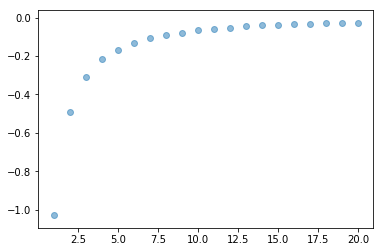

In [40]:
plt.scatter(range(1,21), Klist, alpha = 0.5)

In [42]:
knn = KNeighborsRegressor(n_neighbors=5)
scores = cross_validate(knn, X, Y_regression, cv=10, scoring="neg_mean_squared_error")
sorted(scores.keys()) 
print("KNN K=5 Test MSE:", scores["test_score"].mean())

KNN K=5 Test MSE: -770.4977095435686


In [43]:
# Decision Trees

In [44]:
dtree = tree.DecisionTreeRegressor()
scores = cross_val_score(dtree, X, Y_regression, cv=10)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Accuracy: -0.74 (+/- 0.30)


In [46]:
scores = cross_validate(dtree, X, Y_regression, cv=10, scoring="neg_mean_squared_error")
sorted(scores.keys()) 
print("Decision Tree Test MSE:", scores["test_score"].mean())

Decision Tree Test MSE: -1118.1894010758035


In [47]:
# Random Forest
forest = RandomForestClassifier(min_samples_leaf=10, n_jobs=4)
scores = cross_val_score(forest, X, np.ravel(Y_regression), cv=10)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:605: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)


Accuracy: 0.16 (+/- 0.02)


In [48]:
scores = cross_validate(forest, X, np.ravel(Y_regression), cv=10, scoring="neg_mean_squared_error")
print("Random Forest Test MSE:", scores["test_score"].mean())

/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:605: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)


Random Forest Test MSE: -830.123836459208


In [49]:
# SVM

In [50]:
svr = svm.SVR()
scores = cross_val_score(svr, X, np.ravel(Y_regression), cv=10)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Accuracy: -0.11 (+/- 0.01)


In [15]:
####################
##   Regression   ##
##   Up Sampled   ##
####################

In [18]:
# Simple Linear Regression
lm = linear_model.LinearRegression()
scores = cross_val_score(lm, Xup, Yup_regression, cv=10)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Accuracy: 0.03 (+/- 0.05)


In [19]:
scores = cross_validate(lm, Xup, Yup_regression, cv=10, scoring="neg_mean_squared_error")
sorted(scores.keys()) 
print("Simple Linear Regression Test MSE:", scores["test_score"].mean())

Simple Linear Regression Test MSE: -640.9565611506198


In [20]:
# Lasso
lasso = linear_model.Lasso()
scores = cross_validate(lm, Xup, Yup_regression, cv=10, scoring="neg_mean_squared_error")
sorted(scores.keys()) 
print("Lasso Test MSE:", scores["test_score"].mean())

Lasso Test MSE: -640.9565611506198


In [21]:
# K Nearest Neighbor Regression
Klist = []
for K in range(1,51):
    knn = KNeighborsRegressor(n_neighbors=K)
    Kscores = cross_val_score(knn, Xup, np.ravel(Yup_regression), cv=10)
    Klist.append(Kscores.mean())
    if (K%10 == 0): 
        print(K)

10
20
30
40
50


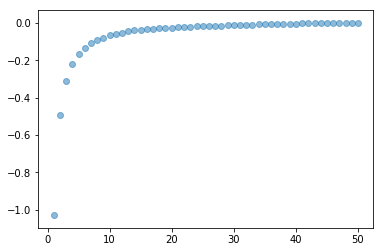

In [22]:
plt.scatter(range(1,51), Klist, alpha = 0.5)

In [25]:
knn = KNeighborsRegressor(n_neighbors=7)
scores = cross_validate(knn, Xup, Yup_regression, cv=10, scoring="neg_mean_squared_error")
sorted(scores.keys()) 
print("KNN K=7 Test MSE:", scores["test_score"].mean())

KNN K=7 Test MSE: -729.90323270387


In [ ]:
# Decision Trees

In [26]:
dtree = tree.DecisionTreeRegressor()
scores = cross_val_score(dtree, Xup, Yup_regression, cv=10)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Accuracy: -0.74 (+/- 0.31)


In [27]:
# Random Forest
forest = RandomForestClassifier(min_samples_leaf=10, n_jobs=4)
scores = cross_val_score(forest, Xup, np.ravel(Yup_regression), cv=10)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:605: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)


Accuracy: 0.16 (+/- 0.01)


In [28]:
scores = cross_validate(forest, Xup, np.ravel(Yup_regression), cv=10, scoring="neg_mean_squared_error")
print("Random Forest Test MSE:", scores["test_score"].mean())

/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:605: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)


Random Forest Test MSE: -832.1145479434042


In [30]:
# SVM
svr = svm.SVR()
scores = cross_val_score(svr, Xup, np.ravel(Yup_regression), cv=10)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Accuracy: -0.11 (+/- 0.01)


In [31]:
scores = cross_validate(svr, Xup, np.ravel(Yup_regression), cv=10, scoring="neg_mean_squared_error")
print("SVM Test MSE:", scores["test_score"].mean())

SVM Test MSE: -734.9396825784903


In [ ]:
########################
##   Classification   ##
########################

In [52]:
# K Nearest Neighbor

Klist = []
for K in range(1,101):
    knn = KNeighborsClassifier(n_neighbors=K)
    Kscores = cross_val_score(knn, X, np.ravel(Y_categorize), cv=10)
    Klist.append(Kscores.mean())
    if (K%10 == 0): 
        print(K)

10
20
30
40
50
60
70
80
90
100


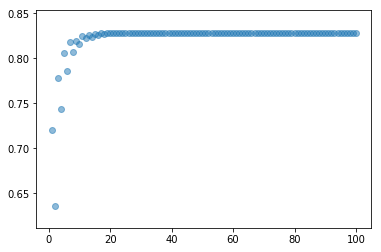

In [53]:
plt.scatter(range(1,101), Klist, alpha = 0.5)

In [54]:
# KNN K = 7
knn = KNeighborsClassifier(n_neighbors=7)
scores = cross_val_score(knn, X, np.ravel(Y_categorize), cv=10)
print("KNN K=7\nAccuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
scores = cross_validate(knn, X, np.ravel(Y_categorize), cv=10, scoring=("accuracy", "precision", "recall", "f1"))
print("Accuracy:", scores["test_accuracy"].mean(), "\nPrecision:", scores["test_precision"].mean(), "\nRecall:", scores["test_recall"].mean(), "\nf1:", scores["test_f1"].mean())

Accuracy: 0.82 (+/- 0.00)
Random Forest
Accuracy: 0.8182571435326459 
Precision: 0.8295865350366786 
Recall: 0.9824711967653803 
f1: 0.8995753448480144


In [55]:
# logistic regression
logreg = LogisticRegression()
scores = cross_val_score(logreg, X, np.ravel(Y_categorize), cv=10)
print("Logistic Regression\nAccuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
scores = cross_validate(logreg, X, np.ravel(Y_categorize), cv=10, scoring=("accuracy", "precision", "recall", "f1"))
print("Accuracy:", scores["test_accuracy"].mean(), "\nPrecision:", scores["test_precision"].mean(), "\nRecall:", scores["test_recall"].mean(), "\nf1:", scores["test_f1"].mean())

Accuracy: 0.83 (+/- 0.00)
Random Forest
Accuracy: 0.8282158718944999 
Precision: 0.8284737875894574 
Recall: 0.999624373825678 
f1: 0.9060371472696435


In [56]:
# LDA
lda = LinearDiscriminantAnalysis()
scores = cross_val_score(lda, X, np.ravel(Y_categorize), cv=10)
print("LDA\nAccuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
scores = cross_validate(lda, X, np.ravel(Y_categorize), cv=10, scoring=("accuracy", "precision", "recall", "f1"))
print("Accuracy:", scores["test_accuracy"].mean(), "\nPrecision:", scores["test_precision"].mean(), "\nRecall:", scores["test_recall"].mean(), "\nf1:", scores["test_f1"].mean())

/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/anaconda3/lib/python3.6/site-packages/sklearn

Accuracy: 0.83 (+/- 0.00)


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/anaconda3/lib/python3.6/site-packages/sklearn

Random Forest
Accuracy: 0.8282159793913285 
Precision: 0.8284737538813436 
Recall: 0.999624373825678 
f1: 0.9060372238170613


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


In [57]:
# QDA
qda = QuadraticDiscriminantAnalysis()
scores = cross_val_score(qda, X, np.ravel(Y_categorize), cv=10)
print("QDA\nAccuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
scores = cross_validate(qda, X, np.ravel(Y_categorize), cv=10, scoring=("accuracy", "precision", "recall", "f1"))
print("Accuracy:", scores["test_accuracy"].mean(), "\nPrecision:", scores["test_precision"].mean(), "\nRecall:", scores["test_recall"].mean(), "\nf1:", scores["test_f1"].mean())

/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:682: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:682: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:682: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:682: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:682: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:682: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/anaconda3/lib/python3.6/site-packages/sklearn/discriminan

Accuracy: 0.24 (+/- 0.03)


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:682: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:682: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:682: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:682: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


Random Forest
Accuracy: 0.23930797549000857 
Precision: 0.8949612149814362 
Recall: 0.09314650832337415 
f1: 0.16770297461298356


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:682: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:682: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:682: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:682: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


In [58]:
# Decision Trees
dtree = tree.DecisionTreeClassifier()
scores = cross_val_score(dtree, X, Y_categorize, cv=10)
print("Decision Tree\nAccuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
scores = cross_validate(dtree, X, np.ravel(Y_categorize), cv=10, scoring=("accuracy", "precision", "recall", "f1"))
print("Accuracy:", scores["test_accuracy"].mean(), "\nPrecision:", scores["test_precision"].mean(), "\nRecall:", scores["test_recall"].mean(), "\nf1:", scores["test_f1"].mean())

Accuracy: 0.73 (+/- 0.02)
Random Forest
Accuracy: 0.7343381851128434 
Precision: 0.8294194580233437 
Recall: 0.8552650399465497 
f1: 0.842083567865755


In [59]:
# Random Forest
forest = RandomForestClassifier(min_samples_leaf=10, n_jobs=4, class_weight="balanced")
scores = cross_val_score(forest, X, np.ravel(Y_categorize), cv=10)
print("Random Forest\nAccuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
scores = cross_validate(forest, X, np.ravel(Y_categorize), cv=10, scoring=("accuracy", "precision", "recall", "f1"))
print("Accuracy:", scores["test_accuracy"].mean(), "\nPrecision:", scores["test_precision"].mean(), "\nRecall:", scores["test_recall"].mean(), "\nf1:", scores["test_f1"].mean())

Accuracy: 0.59 (+/- 0.04)
Random Forest
Accuracy: 0.5910765287226727 
Precision: 0.8312203795341533 
Recall: 0.6355298446366228 
f1: 0.719769361892679


In [60]:
# SVM
svmModel = svm.SVC()
scores = cross_val_score(svmModel, X, np.ravel(Y_categorize), cv=10)
print("SVM\nAccuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
scores = cross_validate(svmModel, X, np.ravel(Y_categorize), cv=10, scoring=("accuracy", "precision", "recall", "f1"))
print("Accuracy:", scores["test_accuracy"].mean(), "\nPrecision:", scores["test_precision"].mean(), "\nRecall:", scores["test_recall"].mean(), "\nf1:", scores["test_f1"].mean())

Accuracy: 0.83 (+/- 0.00)
Random Forest
Accuracy: 0.8282158718944999 
Precision: 0.8284738245412531 
Recall: 0.9996243738256781 
f1: 0.9060372177583357


In [51]:
########################
##   Classification   ##
##   Up Sampled       ##
########################

In [62]:
# K Nearest Neighbor

Klist = []
for K in range(1,51):
    knn = KNeighborsClassifier(n_neighbors=K)
    Kscores = cross_val_score(knn, Xup, np.ravel(Yup_categorize), cv=10)
    Klist.append(Kscores.mean())
    if (K%10 == 0): 
        print(K)

10
20
30
40
50


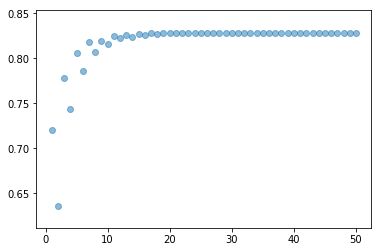

In [63]:
plt.scatter(range(1,51), Klist, alpha = 0.5)

In [64]:
# KNN K = 7
knn = KNeighborsClassifier(n_neighbors=7)
scores = cross_val_score(knn, Xup, np.ravel(Yup_categorize), cv=10)
print("KNN K=7\nAccuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
scores = cross_validate(knn, Xup, np.ravel(Yup_categorize), cv=10, scoring=("accuracy", "precision", "recall", "f1"))
print("Accuracy:", scores["test_accuracy"].mean(), "\nPrecision:", scores["test_precision"].mean(), "\nRecall:", scores["test_recall"].mean(), "\nf1:", scores["test_f1"].mean())

KNN K=7
Accuracy: 0.82 (+/- 0.00)
Accuracy: 0.8182571435326459 
Precision: 0.8295865350366786 
Recall: 0.9824711967653803 
f1: 0.8995753448480144


In [65]:
# logistic regression
logreg = LogisticRegression()
scores = cross_val_score(logreg, Xup, np.ravel(Yup_categorize), cv=10)
print("Logistic Regression\nAccuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
scores = cross_validate(logreg, Xup, np.ravel(Yup_categorize), cv=10, scoring=("accuracy", "precision", "recall", "f1"))
print("Accuracy:", scores["test_accuracy"].mean(), "\nPrecision:", scores["test_precision"].mean(), "\nRecall:", scores["test_recall"].mean(), "\nf1:", scores["test_f1"].mean())

Logistic Regression
Accuracy: 0.83 (+/- 0.00)
Accuracy: 0.8282158718944999 
Precision: 0.8284737875894574 
Recall: 0.999624373825678 
f1: 0.9060371472696435


In [66]:
# LDA
lda = LinearDiscriminantAnalysis()
scores = cross_val_score(lda, Xup, np.ravel(Yup_categorize), cv=10)
print("LDA\nAccuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
scores = cross_validate(lda, Xup, np.ravel(Yup_categorize), cv=10, scoring=("accuracy", "precision", "recall", "f1"))
print("Accuracy:", scores["test_accuracy"].mean(), "\nPrecision:", scores["test_precision"].mean(), "\nRecall:", scores["test_recall"].mean(), "\nf1:", scores["test_f1"].mean())

/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/anaconda3/lib/python3.6/site-packages/sklearn

LDA
Accuracy: 0.83 (+/- 0.00)


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/anaconda3/lib/python3.6/site-packages/sklearn

Accuracy: 0.8282159793913285 
Precision: 0.8284737538813436 
Recall: 0.999624373825678 
f1: 0.9060372238170613


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


In [67]:
# QDA
qda = QuadraticDiscriminantAnalysis()
scores = cross_val_score(qda, Xup, np.ravel(Yup_categorize), cv=10)
print("QDA\nAccuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
scores = cross_validate(qda, Xup, np.ravel(Yup_categorize), cv=10, scoring=("accuracy", "precision", "recall", "f1"))
print("Accuracy:", scores["test_accuracy"].mean(), "\nPrecision:", scores["test_precision"].mean(), "\nRecall:", scores["test_recall"].mean(), "\nf1:", scores["test_f1"].mean())

/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:682: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:682: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:682: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:682: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:682: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:682: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/anaconda3/lib/python3.6/site-packages/sklearn/discriminan

QDA
Accuracy: 0.24 (+/- 0.03)


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:682: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:682: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:682: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:682: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:682: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:682: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/anaconda3/lib/python3.6/site-packages/sklearn/discriminan

Accuracy: 0.23930797549000857 
Precision: 0.8949612149814362 
Recall: 0.09314650832337415 
f1: 0.16770297461298356


In [68]:
# Decision Trees
dtree = tree.DecisionTreeClassifier()
scores = cross_val_score(dtree, Xup, Yup_categorize, cv=10)
print("Decision Tree\nAccuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
scores = cross_validate(dtree, Xup, np.ravel(Yup_categorize), cv=10, scoring=("accuracy", "precision", "recall", "f1"))
print("Accuracy:", scores["test_accuracy"].mean(), "\nPrecision:", scores["test_precision"].mean(), "\nRecall:", scores["test_recall"].mean(), "\nf1:", scores["test_f1"].mean())

Decision Tree
Accuracy: 0.73 (+/- 0.02)
Accuracy: 0.734236066697507 
Precision: 0.8295688909243346 
Recall: 0.8548912958240406 
f1: 0.8420001458024011


In [69]:
# Random Forest
forest = RandomForestClassifier(min_samples_leaf=10, n_jobs=4, class_weight="balanced")
scores = cross_val_score(forest, Xup, np.ravel(Yup_categorize), cv=10)
print("Random Forest\nAccuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
scores = cross_validate(forest, Xup, np.ravel(Yup_categorize), cv=10, scoring=("accuracy", "precision", "recall", "f1"))
print("Accuracy:", scores["test_accuracy"].mean(), "\nPrecision:", scores["test_precision"].mean(), "\nRecall:", scores["test_recall"].mean(), "\nf1:", scores["test_f1"].mean())

Random Forest
Accuracy: 0.58 (+/- 0.04)
Accuracy: 0.5805923473777772 
Precision: 0.8319856656024193 
Recall: 0.6186208637990471 
f1: 0.7091838642775147


In [70]:
# SVM
svmModel = svm.SVC()
scores = cross_val_score(svmModel, Xup, np.ravel(Yup_categorize), cv=10)
print("SVM\nAccuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
scores = cross_validate(svmModel, Xup, np.ravel(Yup_categorize), cv=10, scoring=("accuracy", "precision", "recall", "f1"))
print("Accuracy:", scores["test_accuracy"].mean(), "\nPrecision:", scores["test_precision"].mean(), "\nRecall:", scores["test_recall"].mean(), "\nf1:", scores["test_f1"].mean())

SVM
Accuracy: 0.83 (+/- 0.00)
Accuracy: 0.8282158718944999 
Precision: 0.8284738245412531 
Recall: 0.9996243738256781 
f1: 0.9060372177583357
